In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

import time
import copy
import re

from PIL import Image
import os
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss

from tqdm import tqdm


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertModel

In [2]:
# 완벽한 실험 재현성을 위한 랜덤제어
random_seed = 28
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.cuda.manual_seed(random_seed)

In [3]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 3060


# Vision Data

In [4]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(256),
        transforms.CenterCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),    
}

In [5]:
image_path = "C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/"
image_datasets = {x: datasets.ImageFolder(os.path.join(image_path, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=False, num_workers=4)
              for x in ['train', 'val','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
# dataloaders['train'].dataset.samples
# image_datasets['train'].class_to_idx

In [6]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 6475
     Root location: C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/train
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 925
     Root location: C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'test': Dataset ImageFolder
     Number of datapoints: 1850
     Root location: C:/Users/ANDlab3/Desktop/paper/fashion-dataset/data/test
     StandardTransform
 Transfo

In [7]:
dataset_sizes

{'train': 6475, 'val': 925, 'test': 1850}

In [8]:
class_num = len(class_names)

In [9]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [10]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

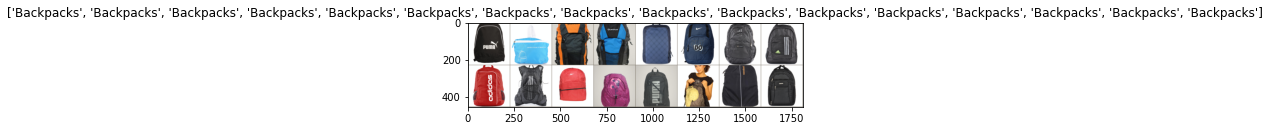

In [11]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Vison Module

In [12]:
model_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/model/"

vision_module = models.resnet50(pretrained=False)
num_ftrs = vision_module.fc.in_features
vision_module.fc = nn.Linear(num_ftrs, class_num)

vision_module = vision_module.to(device) # 모델 선언
vision_module.load_state_dict(torch.load(model_path+'vision_model.pt')) # fine tune 파라메타 불러오기

<All keys matched successfully>

In [13]:
vision_module

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
# 파라메타 번호 확인 하기
i = 0
for name, param in vision_module.named_parameters():
    
    print(i,name)
    i+= 1

0 conv1.weight
1 bn1.weight
2 bn1.bias
3 layer1.0.conv1.weight
4 layer1.0.bn1.weight
5 layer1.0.bn1.bias
6 layer1.0.conv2.weight
7 layer1.0.bn2.weight
8 layer1.0.bn2.bias
9 layer1.0.conv3.weight
10 layer1.0.bn3.weight
11 layer1.0.bn3.bias
12 layer1.0.downsample.0.weight
13 layer1.0.downsample.1.weight
14 layer1.0.downsample.1.bias
15 layer1.1.conv1.weight
16 layer1.1.bn1.weight
17 layer1.1.bn1.bias
18 layer1.1.conv2.weight
19 layer1.1.bn2.weight
20 layer1.1.bn2.bias
21 layer1.1.conv3.weight
22 layer1.1.bn3.weight
23 layer1.1.bn3.bias
24 layer1.2.conv1.weight
25 layer1.2.bn1.weight
26 layer1.2.bn1.bias
27 layer1.2.conv2.weight
28 layer1.2.bn2.weight
29 layer1.2.bn2.bias
30 layer1.2.conv3.weight
31 layer1.2.bn3.weight
32 layer1.2.bn3.bias
33 layer2.0.conv1.weight
34 layer2.0.bn1.weight
35 layer2.0.bn1.bias
36 layer2.0.conv2.weight
37 layer2.0.bn2.weight
38 layer2.0.bn2.bias
39 layer2.0.conv3.weight
40 layer2.0.bn3.weight
41 layer2.0.bn3.bias
42 layer2.0.downsample.0.weight
43 layer2.0.do

In [15]:
# 합성곱 층은 0~9까지이다. 따라서 9번째 변수까지 역추적을 비활성화 한 후 for문을 종료한다.

for i, (name, param) in enumerate(vision_module.named_parameters()):
    
    param.requires_grad = False
    if i == 160:
        print('end')

end


In [16]:
# vision module freeze check
print(vision_module.conv1.weight.requires_grad)
print(vision_module.layer1[0].conv1.weight.requires_grad)
print(vision_module.fc.weight.requires_grad)
print(vision_module.fc.bias.requires_grad)

False
False
False
False


# NLP Data

In [17]:
nlp_train_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/train.csv"
nlp_val_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/val.csv"
nlp_test_path = "C:/Users/ANDlab3/Desktop/VisionAndNLP/data/test.csv"

In [18]:
nlp_train_data = pd.read_csv(nlp_train_path)
nlp_val_data = pd.read_csv(nlp_val_path)
nlp_test_data = pd.read_csv(nlp_test_path)

In [19]:
X_train = nlp_train_data['productDisplayName']
y_train = nlp_train_data['label']

In [20]:
X_val = nlp_val_data['productDisplayName']
y_val = nlp_val_data['label']

In [21]:
X_test = nlp_test_data['productDisplayName']
y_test = nlp_test_data['label']

In [22]:
nlp_train_data[:8]

,articleType,image,productDisplayName,label,image_num
0,Backpacks,1556.jpg,Quechua Forclaz Large Backpack - 50 ltr Orange,0,1556
1,Backpacks,1557.jpg,Quechua Spacious Blue-Black Backpack,0,1557
2,Backpacks,1623.jpg,Reebok Unisex Red Backpack,0,1623
3,Backpacks,1648.jpg,Quechua Ultralight Backpack Purple 16 ltr Bag,0,1648
4,Backpacks,1697.jpg,Puma Deck Black Backpack,0,1697
5,Backpacks,1790.jpg,Quechua Unisex Ultralight Beige Bag,0,1790
6,Backpacks,1795.jpg,Newfeel 22L Black Bag,0,1795
7,Backpacks,1800.jpg,Quechua Unisex Black Solid Backpack,0,1800


In [23]:
def text_preprocessing(text):
    """
    - Remove entity mentions (eg. '@united')
    - Correct errors (eg. '&amp;' to '&')
    @param    text (str): a string to be processed.
    @return   text (Str): the processed string.
    """
    # Remove '@name'
    text = re.sub(r'(@.*?)[\s]', ' ', text)

    # Replace '&amp;' with '&'
    text = re.sub(r'&amp;', '&', text)

    # Remove trailing whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [24]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Create a function to tokenize a set of texts
def preprocessing_for_bert(data):
    """Perform required preprocessing steps for pretrained BERT.
    @param    data (np.array): Array of texts to be processed.
    @return   input_ids (torch.Tensor): Tensor of token ids to be fed to a model.
    @return   attention_masks (torch.Tensor): Tensor of indices specifying which
                  tokens should be attended to by the model.
    """
    # Create empty lists to store outputs
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in data:
        # `encode_plus` will:
        #    (1) Tokenize the sentence
        #    (2) Add the `[CLS]` and `[SEP]` token to the start and end
        #    (3) Truncate/Pad sentence to max length
        #    (4) Map tokens to their IDs
        #    (5) Create attention mask
        #    (6) Return a dictionary of outputs
        encoded_sent = tokenizer.encode_plus(
            text=text_preprocessing(sent),  # Preprocess sentence
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]`
            max_length=MAX_LEN,                  # Max length to truncate/pad
            pad_to_max_length=True,         # Pad sentence to max length
            #return_tensors='pt',           # Return PyTorch tensor
            return_attention_mask=True      # Return attention mask
            )
        
        # Add the outputs to the lists
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [25]:
# Specify `MAX_LEN`
MAX_LEN = 30

# # Print sentence 0 and its encoded token ids
token_ids = list(preprocessing_for_bert([X_train[0]])[0].squeeze().numpy())
print('Original: ', X_train[0])
print('Token IDs: ', token_ids)

# Run function `preprocessing_for_bert` on the train set and the validation set
print('Tokenizing data...')
train_inputs, train_masks = preprocessing_for_bert(X_train)
val_inputs, val_masks = preprocessing_for_bert(X_val)
test_inputs, test_masks = preprocessing_for_bert(X_test)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\ANDlab3\anaconda3\envs\GAN\lib\site-packages\transformers\tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Quechua Forclaz Large  Backpack - 50 ltr Orange
Token IDs:  [101, 10861, 26200, 2005, 20464, 10936, 2312, 13383, 1011, 2753, 8318, 2099, 4589, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tokenizing data...


In [26]:
print(train_inputs.size())
print(train_masks.size())

print(val_inputs.size())
print(val_masks.size())

print(test_inputs.size())
print(test_masks.size())

torch.Size([6475, 30])
torch.Size([6475, 30])
torch.Size([925, 30])
torch.Size([925, 30])
torch.Size([1850, 30])
torch.Size([1850, 30])


In [27]:
# Convert other data types to torch.Tensor
train_labels = torch.tensor(y_train)
val_labels = torch.tensor(y_val)
test_labels = torch.tensor(y_test)

# For fine-tuning BERT, the authors recommend a batch size of 16 or 32.
batch_size = 16

# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# NLP  Module

In [28]:
%%time
# Create the BertClassfier class
class BertClassifier(nn.Module):
    """Bert Model for Classification Tasks.
    """
    def __init__(self, freeze_bert=False):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(BertClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels
        D_in, H, D_out = 768, 50, 37

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate an one-layer feed-forward classifier
        self.classifier = nn.Sequential(
            nn.Linear(D_in, H),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(H, D_out)
        )

        # Freeze the BERT model
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False
        
    def forward(self, input_ids, attention_mask):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        last_hidden_state_cls = outputs[0][:, 0, :]

        # Feed input to classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Wall time: 0 ns


In [29]:
# Instantiate Bert Classifier
NLP_module = BertClassifier(freeze_bert=True)

# Tell PyTorch to run the model on GPU
NLP_module.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

# LanguageAndVisionConcat

In [52]:
class LanguageAndVisionConcat(nn.Module):    
    def __init__(
        self,
        nlp_module,
        vision_module,
        num_classes,
        language_feature_dim,
        vision_feature_dim,
        fusion_output_size,
        dropout_p):
        super(LanguageAndVisionConcat, self).__init__()
        self.nlp_module = nlp_module
        self.vision_module = vision_module
        self.fusion = torch.nn.Linear(
                        in_features=(language_feature_dim + vision_feature_dim), 
                        out_features=fusion_output_size
        )
        self.fc = torch.nn.Linear(
            in_features=fusion_output_size, 
            out_features=num_classes
        )
        self.dropout = torch.nn.Dropout(dropout_p)
   
    
    def forward(self, text, text2 , image):
        text_features = torch.nn.functional.relu(
            self.nlp_module(text, text2)
        )
        image_features = torch.nn.functional.relu(
            self.vision_module(image)
        )
        combined = torch.cat(
            [text_features, image_features], dim=1
        )
        fused = self.dropout(
            torch.nn.functional.relu(
            self.fusion(combined)
            ))
        logits = self.fc(fused)

        return logits

In [53]:
model = LanguageAndVisionConcat(
        nlp_module = NLP_module,
        vision_module = vision_module,
        num_classes = class_num,
        language_feature_dim = 37,
        vision_feature_dim = 37,
        fusion_output_size = 37,
        dropout_p = 0.2
)

In [54]:
model = model.to(device)

In [55]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [56]:
vision_train =  dataloaders['train']
nlp_train = train_dataloader

In [61]:
print(len(vision_train))
print(len(nlp_train))

405
405


In [65]:
loss_ = [] # 그래프를 그리기 위한 loss 저장용 리스트 
n = len(vision_train) # 배치 개수

for epoch in range(3):
    model.train()
    running_loss = 0.0
    for nlp, vision in zip(nlp_train, vision_train):
        b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in nlp)
        v_image, v_label = tuple(k.to(device) for k in vision)

        optimizer.zero_grad()

        outputs = model(b_input_ids, b_attn_mask, v_image)
        loss = criterion(outputs, v_label) # 손실함수 계산
        loss.backward() # 손실함수 기준으로 역전파 선언
        optimizer.step() # 가중치 최적화
        # print statistics
        running_loss += loss.item()

    loss_.append(running_loss / n)
    print('[%d] loss: %.3f' %(epoch + 1, running_loss / n))
          
print('done')

[1] loss: 3.591
[2] loss: 3.600
[3] loss: 3.581
done
